In [ ]:
# intsall first use
!pip install transformers torch

In [2]:
# tokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model_name = 'google/flan-t5-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
print('flan-t5-large model loaded.')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

flan-t5-large model loaded.


In [3]:
# Prompt builder
def build_prompt(symptom_text):
    return f'''
You are a hospital triage expert.
Classify the following symptoms into one of:
- non-urgent: mild and not likely to worsen
- urgent: moderately serious and may worsen
- emergency: life-threatening or critical condition
- futile: beyond medical help

Only respond with one label from the list above.
Symptoms: {symptom_text}
Answer:'''

In [4]:
# LLM output
def extract_label_from_response(response):
    response = response.lower()
    for label in ['non-urgent', 'urgent', 'emergency', 'futile']:
        if label in response:
            return label
    return 'unknown'

In [5]:
def classify(symptom_text):
    prompt = build_prompt(symptom_text)
    inputs = tokenizer(prompt, return_tensors='pt')
    outputs = model.generate(**inputs, max_new_tokens=20)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return extract_label_from_response(decoded.strip())

In [6]:
import pandas as pd
import random

In [7]:
triage_levels = ["non-urgent", "urgent", "emergency", "futile"]

In [8]:
symptom_templates = {
    "non-urgent": [
        "runny nose, itchy eyes",
        "mild sore throat, dry cough",
        "mild headache, slight fatigue",
        "sneezing, no fever",
        "intermittent mild nausea"
    ],
    "urgent": [
        "persistent vomiting, high fever",
        "severe abdominal pain, nausea",
        "deep cut, moderate bleeding",
        "dehydration, dizziness",
        "severe back pain, limited mobility"
    ],
    "emergency": [
        "chest pain, shortness of breath",
        "heavy bleeding, confusion",
        "loss of consciousness, seizure",
        "stroke symptoms, slurred speech",
        "severe burns, intense pain"
    ],
    "futile": [
        "no pulse, not breathing, unresponsive",
        "flatline ECG, no vital signs",
        "multiple organ failure, non-reactive pupils",
        "catastrophic brain injury, fixed dilated pupils",
        "full-body burns, no vital signs"
    ]
}

In [9]:
def generate_test_dataset(n=50):
    data = []
    for i in range(n):
        label = random.choice(triage_levels)
        symptoms = random.choice(symptom_templates[label])
        data.append({
            "patient_id": f"PT{i:04}",
            "symptoms": symptoms,
            "true_label": label
        })
    return pd.DataFrame(data)

# Generate dataset
test_df = generate_test_dataset(50)

In [11]:
test_df["prediction"] = test_df["symptoms"].apply(classify)

In [12]:
test_df.head()

,patient_id,symptoms,true_label,prediction
0,PT0000,"heavy bleeding, confusion",emergency,emergency
1,PT0001,"deep cut, moderate bleeding",urgent,urgent
2,PT0002,"mild sore throat, dry cough",non-urgent,non-urgent
3,PT0003,"heavy bleeding, confusion",emergency,emergency
4,PT0004,"severe abdominal pain, nausea",urgent,urgent


In [14]:
# distrubations
def generate_recommendations(label):
    label = label.lower()

    mapping = {
        "non-urgent": {
            "recommended_department": "General Practice / Family Medicine",
            "recommended_tests": "None or basic vitals (BP, temperature)",
            "action_plan": "Wait at home, monitor symptoms, schedule GP visit"
        },
        "urgent": {
            "recommended_department": "Internal Medicine / Urgent Care",
            "recommended_tests": "CBC, urine test, blood pressure monitoring",
            "action_plan": "Visit urgent care within 24 hours"
        },
        "emergency": {
            "recommended_department": "Emergency Room (ER)",
            "recommended_tests": "ECG, blood panel, imaging (CT/X-ray)",
            "action_plan": "Immediate ER admission"
        },
        "futile": {
            "recommended_department": "Palliative / Do Not Transfer",
            "recommended_tests": "None",
            "action_plan": "No further intervention, notify next of kin"
        }
    }

    return mapping.get(label, {
        "recommended_department": "Unknown",
        "recommended_tests": "Unknown",
        "action_plan": "Unknown"
    })

In [16]:
recommendations = test_df["prediction"].apply(generate_recommendations)
recommendations_df = pd.DataFrame(recommendations.tolist())

In [17]:
test_df = pd.concat([test_df, recommendations_df], axis=1)

In [18]:
test_df.head()

,patient_id,symptoms,true_label,prediction,recommended_department,recommended_tests,action_plan
0,PT0000,"heavy bleeding, confusion",emergency,emergency,Emergency Room (ER),"ECG, blood panel, imaging (CT/X-ray)",Immediate ER admission
1,PT0001,"deep cut, moderate bleeding",urgent,urgent,Internal Medicine / Urgent Care,"CBC, urine test, blood pressure monitoring",Visit urgent care within 24 hours
2,PT0002,"mild sore throat, dry cough",non-urgent,non-urgent,General Practice / Family Medicine,"None or basic vitals (BP, temperature)","Wait at home, monitor symptoms, schedule GP visit"
3,PT0003,"heavy bleeding, confusion",emergency,emergency,Emergency Room (ER),"ECG, blood panel, imaging (CT/X-ray)",Immediate ER admission
4,PT0004,"severe abdominal pain, nausea",urgent,urgent,Internal Medicine / Urgent Care,"CBC, urine test, blood pressure monitoring",Visit urgent care within 24 hours


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('patient_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('symptoms').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('true_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('prediction').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['symptoms'].value_counts()
    for x_label, grp in _df_4.groupby('patient_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('patient_id')
_ = plt.ylabel('symptoms')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['true_label'].value_counts()
    for x_label, grp in _df_5.groupby('symptoms')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('symptoms')
_ = plt.ylabel('true_label')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['prediction'].value_counts()
    for x_label, grp in _df_6.groupby('true_label')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('true_label')
_ = plt.ylabel('prediction')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['recommended_department'].value_counts()
    for x_label, grp in _df_7.groupby('prediction')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('prediction')
_ = plt.ylabel('recommended_department')

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

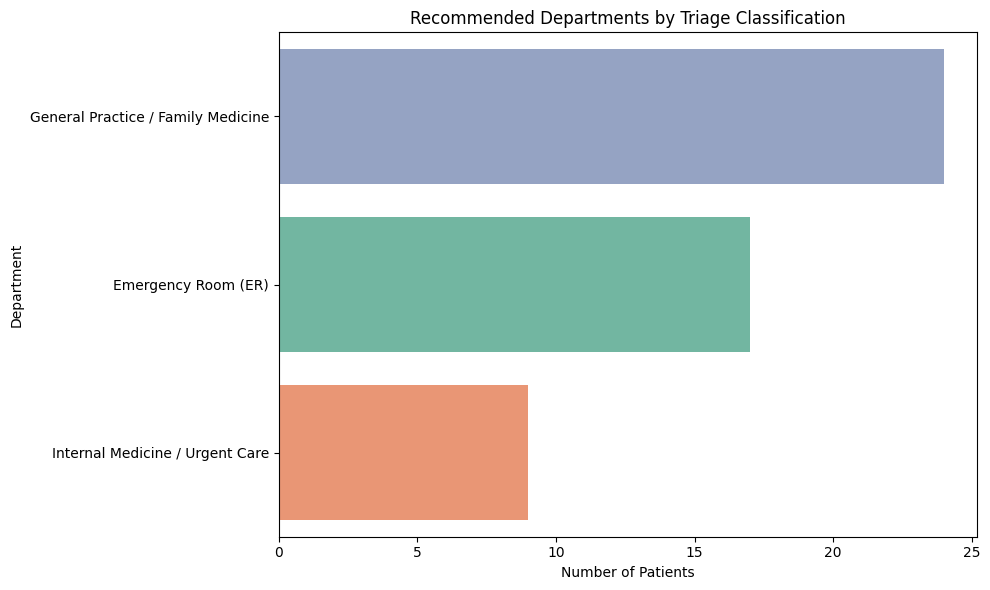

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=test_df,
    y="recommended_department",
    hue="recommended_department",
    legend=False,
    order=test_df["recommended_department"].value_counts().index,
    palette="Set2"
)
plt.title("Recommended Departments by Triage Classification")
plt.xlabel("Number of Patients")
plt.ylabel("Department")
plt.tight_layout()
plt.show()

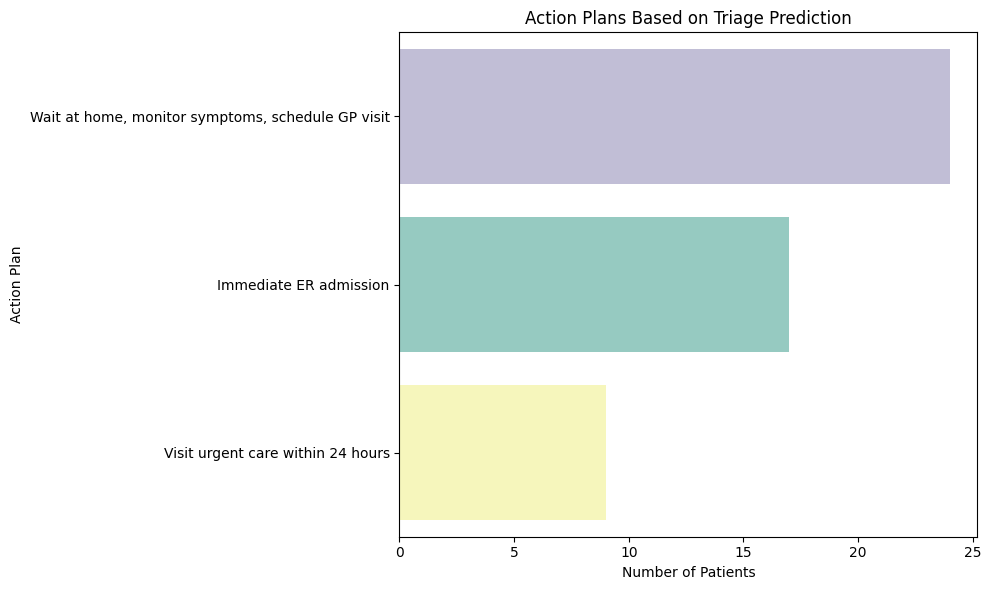

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=test_df,
    y="action_plan",
    hue="action_plan",
    legend=False,
    order=test_df["action_plan"].value_counts().index,
    palette="Set3"
)
plt.title("Action Plans Based on Triage Prediction")
plt.xlabel("Number of Patients")
plt.ylabel("Action Plan")
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
y_true = test_df["true_label"].str.lower()
y_pred = test_df["prediction"].str.lower()

In [30]:
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()

labels = ["non-urgent", "urgent", "emergency", "futile"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

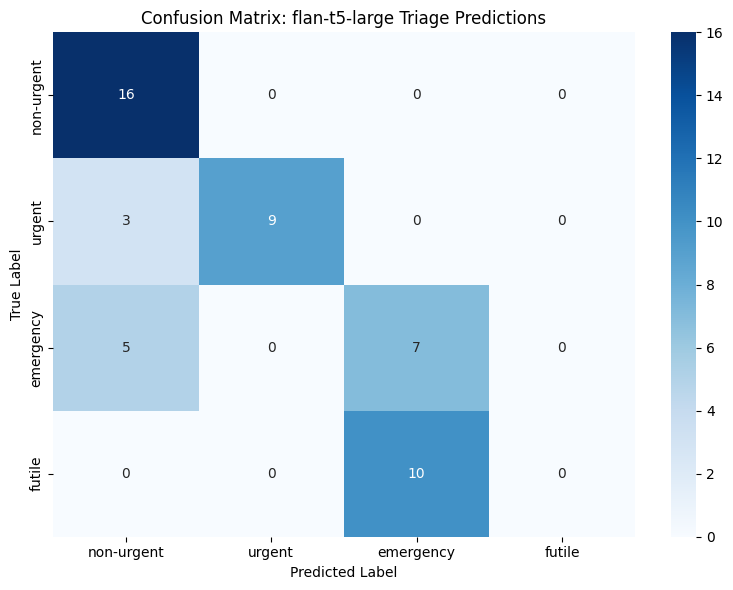

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: flan-t5-large Triage Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [36]:
print("Classification Report:")
display(report_df)

Classification Report:


,precision,recall,f1-score,support
emergency,0.411765,0.583333,0.482759,12.00
futile,0.000000,0.000000,0.000000,10.00
non-urgent,0.666667,1.000000,0.800000,16.00
urgent,1.000000,0.750000,0.857143,12.00
accuracy,0.640000,0.640000,0.640000,0.64
macro avg,0.519608,0.583333,0.534975,50.00
weighted avg,0.552157,0.640000,0.577576,50.00
